In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy.stats import pearsonr
from scipy import signal as sig
from scipy.io import loadmat
from scipy.signal import ellip, lfilter, filtfilt, find_peaks, butter, sosfiltfilt,sosfilt

In [2]:
%matplotlib inline

In [3]:
#open data
leaderboard_data = loadmat('..\\leaderboard_data.mat')
raw_training_data = loadmat('..\\raw_training_data.mat')

In [4]:
train_ecog_s1 = raw_training_data['train_ecog'][0][0]
leaderboard_data_s1 = leaderboard_data['leaderboard_ecog'][0][0]

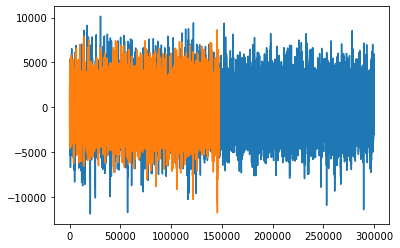

In [5]:
plt.plot(train_ecog_s1.transpose()[0])
plt.plot(leaderboard_data_s1.transpose()[0])


In [6]:
#glove data for training - per subject
train_dg_s1 = raw_training_data['train_dg'][0][0]
train_dg_s2 = raw_training_data['train_dg'][1][0]
train_dg_s3 = raw_training_data['train_dg'][2][0]

In [7]:
train_dg_s1_downsample = train_dg_s1[::50][:-1]
train_dg_s2_downsample = train_dg_s2[::50][:-1]
train_dg_s3_downsample = train_dg_s3[::50][:-1]

In [8]:
file_s1 = open("all_feats_s1_norm_train_fx.npy", "rb")
feats_s1_train = np.load(file_s1)
file_s1.close()

file_s2 = open("all_feats_s2_norm_train_fx.npy", "rb")
feats_s2_train = np.load(file_s2)
file_s2.close()

file_s3 = open("all_feats_s3_norm_train_fx.npy", "rb")
feats_s3_train = np.load(file_s3)
file_s3.close()

In [9]:
# Problematic features, drop them for now. 
def clean_features(feats):
    bad_feat_inds = np.concatenate((np.arange(2,len(feats.transpose()),7),
                                   np.arange(3,len(feats.transpose()),7),
                                   np.arange(4,len(feats.transpose()),7),
                                  ))
    feats_cleaned = np.delete(feats, bad_feat_inds, axis=1)
    
    return feats_cleaned

feats_s1_train = clean_features(feats_s1_train)
feats_s2_train = clean_features(feats_s2_train)
feats_s3_train = clean_features(feats_s3_train)

In [10]:
print(np.shape(feats_s1_train))

(5999, 244)


## Prediction Interpolation

In [11]:
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [12]:
def repeat_preds(preds, window_to_time_ratio=50):
    pred_all = []
    for row in preds:
        for i in range(window_to_time_ratio):
            pred_all.append(row)

    # For out problem, it is short 50 entries, so add the last row 50 more times
    for i in range(window_to_time_ratio):
        pred_all.append(row)
    
    return np.array(pred_all)

def interp_preds(preds, time_length):
    # N samples
    preds_sample_orig = np.arange(len(preds))
    
    # T time points
    preds_sample_target = np.arange(time_length)
    
    preds = preds.transpose()

    preds_interp = []
    
    for finger_preds in preds:
        f = interp1d(preds_sample_orig, finger_preds)
        new_preds = f(preds_sample_target)
        preds_interp.append(new_preds)
    
    preds_interp = np.array(preds_interp).transpose()
    
    return preds_interp

def spline_preds(preds, time_length):
    # N samples
    preds_sample_orig = np.arange(len(preds))
    
    # T time points
    preds_sample_target = np.linspace(0,len(preds),time_length)
    print(preds_sample_target)
    preds = preds.transpose()

    preds_interp = []
    
    for finger_preds in preds:
        f = CubicSpline(preds_sample_orig, finger_preds, bc_type="natural")
        new_preds = f(preds_sample_target)
        preds_interp.append(new_preds)
    
    preds_interp = np.array(preds_interp).transpose()
    
    return preds_interp

def compute_corr(preds, truth):
    subj_corr = []
    for i in range(5):
        finger_pred = preds.transpose()[i]
        finger_truth = truth.transpose()[i]
        subj_corr.append(pearsonr(finger_pred, finger_truth)[0])
    
    return subj_corr

## Subject 1

In [13]:
reg_rfr_s1 = pickle.load(open('subject1_rfr_1000_run2.model', 'rb'))
pred_s1 = reg_rfr_s1.predict(feats_s1_train)

In [14]:
pred_s1_spline = spline_preds(pred_s1, 300000)
#pred_s1_interp = repeat_preds(pred_s1, len(train_dg_s1))
print(pred_s1_spline.shape)
#print(pred_s1_interp.shape)
print(train_dg_s1.shape)

[0.00000000e+00 1.99967333e-02 3.99934666e-02 ... 5.99896001e+03
 5.99898000e+03 5.99900000e+03]
(300000, 5)
(300000, 5)


In [15]:
# plt.scatter(train_dg_s1.transpose()[0], pred_s1_repeat.transpose()[0], s=3)
# plt.scatter(train_dg_s1.transpose()[1], pred_s1_repeat.transpose()[1], s=3)
# plt.scatter(train_dg_s1.transpose()[2], pred_s1_repeat.transpose()[2], s=3)
# plt.scatter(train_dg_s1.transpose()[3], pred_s1_repeat.transpose()[3], s=3)
# plt.scatter(train_dg_s1.transpose()[4], pred_s1_repeat.transpose()[4], s=3)


In [16]:
subj1_corr = compute_corr(pred_s1_spline, train_dg_s1)
print(subj1_corr)

[0.8410224994360866, 0.8715811126927883, 0.8659282519386594, 0.856764546828361, 0.8601223740463193]


In [92]:
def convolve_gaussian(preds):
    preds_t = preds.transpose()
    preds_t_convolve = []
    
    fs = 1000
    gaussian_filter = np.exp(-1*(np.arange(int(-1*1000),int(1*1000)))**2/(0.75*1000)**2)
    gaussian_filter_scaled = 1/np.sum(gaussian_filter) * gaussian_filter
    
    for row in preds_t:
        preds_t_convolve.append(np.convolve(gaussian_filter_scaled, row, "same"))
    
    return np.array(preds_t_convolve).transpose()
    

pred1_train_postprocess = convolve_gaussian(spline_preds(pred_s1, 300000))

print(compute_corr(pred1_train_postprocess, train_dg_s1))

[0.00000000e+00 1.99967333e-02 3.99934666e-02 ... 5.99896001e+03
 5.99898000e+03 5.99900000e+03]
[0.7207804207232205, 0.7263685582818235, 0.7462247241269627, 0.8105162143574839, 0.7864228954034395]


## Subject 2

In [93]:
reg_rfr_s2 = pickle.load(open('subject2_rfr_1000_run2.model', 'rb'))
pred_s2 = reg_rfr_s2.predict(feats_s2_train)

In [94]:
pred_s2_spline = spline_preds(pred_s2, 300000)
#pred_s1_interp = repeat_preds(pred_s1, len(train_dg_s1))
print(pred_s2_spline.shape)
#print(pred_s1_interp.shape)
print(train_dg_s2.shape)

[0.00000000e+00 1.99967333e-02 3.99934666e-02 ... 5.99896001e+03
 5.99898000e+03 5.99900000e+03]
(300000, 5)
(300000, 5)


In [95]:
# plt.scatter(train_dg_s2.transpose()[0], pred_s2_repeat.transpose()[0], s=3)
# plt.scatter(train_dg_s2.transpose()[1], pred_s2_repeat.transpose()[1], s=3)
# plt.scatter(train_dg_s2.transpose()[2], pred_s2_repeat.transpose()[2], s=3)
# plt.scatter(train_dg_s2.transpose()[3], pred_s2_repeat.transpose()[3], s=3)
# plt.scatter(train_dg_s2.transpose()[4], pred_s2_repeat.transpose()[4], s=3)


In [96]:
subj2_corr = compute_corr(pred_s2_spline, train_dg_s2)
print(subj2_corr)

[0.8948945153179355, 0.869927452165907, 0.8610763184208142, 0.8662547246289932, 0.873212752890471]


In [97]:
pred2_train_postprocess = convolve_gaussian(spline_preds(pred_s2, 300000))

print(compute_corr(pred2_train_postprocess, train_dg_s2))

[0.00000000e+00 1.99967333e-02 3.99934666e-02 ... 5.99896001e+03
 5.99898000e+03 5.99900000e+03]
[0.7909779384298672, 0.7483028642762097, 0.7269504605110577, 0.7346863540131512, 0.7286710299886487]


## Subject 3

In [98]:
reg_rfr_s3 = pickle.load(open('subject3_rfr_1000_run2.model', 'rb'))
pred_s3 = reg_rfr_s3.predict(feats_s3_train)

In [99]:
pred_s3_spline = spline_preds(pred_s3, 300000)
#pred_s1_interp = repeat_preds(pred_s1, len(train_dg_s1))
print(pred_s3_spline.shape)
#print(pred_s1_interp.shape)
print(train_dg_s3.shape)

[0.00000000e+00 1.99967333e-02 3.99934666e-02 ... 5.99896001e+03
 5.99898000e+03 5.99900000e+03]
(300000, 5)
(300000, 5)


In [100]:
subj3_corr = compute_corr(pred_s3_spline, train_dg_s3)
print(subj3_corr)

[0.902497957011476, 0.9054117753631112, 0.8887490798131439, 0.8976933058639753, 0.8894349563288955]


In [101]:
# plt.scatter(train_dg_s3.transpose()[0], pred_s3_repeat.transpose()[0], s=3)
# plt.scatter(train_dg_s3.transpose()[1], pred_s3_repeat.transpose()[1], s=3)
# plt.scatter(train_dg_s3.transpose()[2], pred_s3_repeat.transpose()[2], s=3)
# plt.scatter(train_dg_s3.transpose()[3], pred_s3_repeat.transpose()[3], s=3)
# plt.scatter(train_dg_s3.transpose()[4], pred_s3_repeat.transpose()[4], s=3)


In [102]:
#pred3_train_postprocess = convolve_gaussian(spline_preds(pred_s3, 300000))
pred3_train_postprocess = convolve_gaussian(spline_preds(pred_s3, 300000))
print(compute_corr(pred3_train_postprocess, train_dg_s3))

[0.00000000e+00 1.99967333e-02 3.99934666e-02 ... 5.99896001e+03
 5.99898000e+03 5.99900000e+03]
[0.8921463337875774, 0.8512264154920897, 0.9060048728924838, 0.8969880229364793, 0.8728124557572474]


[0.00000000e+00 1.99967333e-02 3.99934666e-02 ... 5.99896001e+03
 5.99898000e+03 5.99900000e+03]
[0.00000000e+00 1.99967333e-02 3.99934666e-02 ... 5.99896001e+03
 5.99898000e+03 5.99900000e+03]
[0.00000000e+00 1.99967333e-02 3.99934666e-02 ... 5.99896001e+03
 5.99898000e+03 5.99900000e+03]
[0.7256000046309095, 0.7147288234263156, 0.7455744840864589, 0.8089913096711547, 0.7794596699090182]
[0.787906765439486, 0.7413314438203947, 0.7302863167142518, 0.7333038680975648, 0.7181990556145555]
[0.8913771629359537, 0.8523703993478606, 0.8874797894959494, 0.8959493576356569, 0.8800425776339924]


Text(0.5, 1.0, 'Subject 1 Training Set Finger Movements')

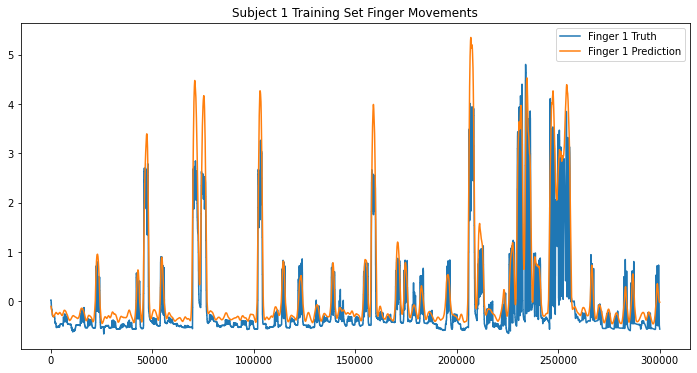

In [103]:
plt.figure(figsize=(12,6))
pred_s1_train_spline = spline_preds(pred_s1, 300000)
pred_s2_train_spline = spline_preds(pred_s2, 300000)
pred_s3_train_spline = spline_preds(pred_s3, 300000)

pred1_train_postprocess[pred1_train_postprocess > 0] = pred1_train_postprocess[pred1_train_postprocess > 0] * 3
pred2_train_postprocess[pred2_train_postprocess > 0] = pred2_train_postprocess[pred2_train_postprocess > 0] * 3
pred3_train_postprocess[pred3_train_postprocess > 0] = pred3_train_postprocess[pred3_train_postprocess > 0] * 3


print(compute_corr(pred1_train_postprocess, train_dg_s1))
print(compute_corr(pred2_train_postprocess, train_dg_s2))
print(compute_corr(pred3_train_postprocess, train_dg_s3))
plt.plot(np.linspace(0,len(train_dg_s3), 300000), train_dg_s3.transpose()[4])
plt.plot(np.linspace(0,len(train_dg_s3), 300000), pred3_train_postprocess.transpose()[4])
plt.legend(["Finger 1 Truth", "Finger 1 Prediction"])
plt.title("Subject 1 Training Set Finger Movements")

# Predict Leaderboard

In [104]:
file_s1 = open("all_feats_s1_norm_test_fx.npy", "rb")
feats_s1_test = np.load(file_s1)
file_s1.close()

file_s2 = open("all_feats_s2_norm_test_fx.npy", "rb")
feats_s2_test = np.load(file_s2)
file_s2.close()

file_s3 = open("all_feats_s3_norm_test_fx.npy", "rb")
feats_s3_test = np.load(file_s3)
file_s3.close()

feats_s1_test = clean_features(feats_s1_test)
feats_s2_test = clean_features(feats_s2_test)
feats_s3_test = clean_features(feats_s3_test)

In [105]:
pred_s1_test = reg_rfr_s1.predict(feats_s1_test)

pred_s2_test = reg_rfr_s2.predict(feats_s2_test)

pred_s3_test = reg_rfr_s3.predict(feats_s3_test)


In [106]:
pred_s1_test_spline = spline_preds(pred_s1_test, 147500)
#pred_s1_test_spline[-50:] = pred_s1_test[-1] # The last 50 entries of the spline are screwed up
pred_s2_test_spline = spline_preds(pred_s2_test, 147500)
#pred_s2_test_spline[-50:] = pred_s2_test[-1]
pred_s3_test_spline = spline_preds(pred_s3_test, 147500)
#pred_s3_test_spline[-50:] = pred_s3_test[-1]

[0.00000000e+00 1.99933559e-02 3.99867118e-02 ... 2.94896001e+03
 2.94898001e+03 2.94900000e+03]
[0.00000000e+00 1.99933559e-02 3.99867118e-02 ... 2.94896001e+03
 2.94898001e+03 2.94900000e+03]
[0.00000000e+00 1.99933559e-02 3.99867118e-02 ... 2.94896001e+03
 2.94898001e+03 2.94900000e+03]


In [107]:
print(pred_s1_test)
print(pred_s1_test_spline)


[[-0.03195505  0.48573649 -0.10860387 -0.3057707  -0.04720863]
 [-0.01071474  0.31961265  0.09451283  0.04971277  0.17362348]
 [-0.07758507 -0.00193978  0.11547705  0.08203594  0.01491921]
 ...
 [-0.13190768  0.15699012  0.05201093 -0.12311575  0.02381362]
 [ 0.03631774 -0.1421963   0.6547933   0.22095923  0.13294037]
 [-0.21480726  0.32097624  0.77224335 -0.04197982 -0.05064853]]
[[-0.03195505  0.48573649 -0.10860387 -0.3057707  -0.04720863]
 [-0.03123662  0.48412142 -0.10244854 -0.29713362 -0.04038816]
 [-0.03051889  0.48250225 -0.09629823 -0.28850021 -0.03357346]
 ...
 [-0.46380348  0.78486073  0.87404518 -0.31073054 -0.23389516]
 [-0.46499146  0.78480516  0.88169823 -0.30807971 -0.23417562]
 [-0.46593226  0.78414878  0.8896934  -0.30491887 -0.23423744]]


(147500, 5)


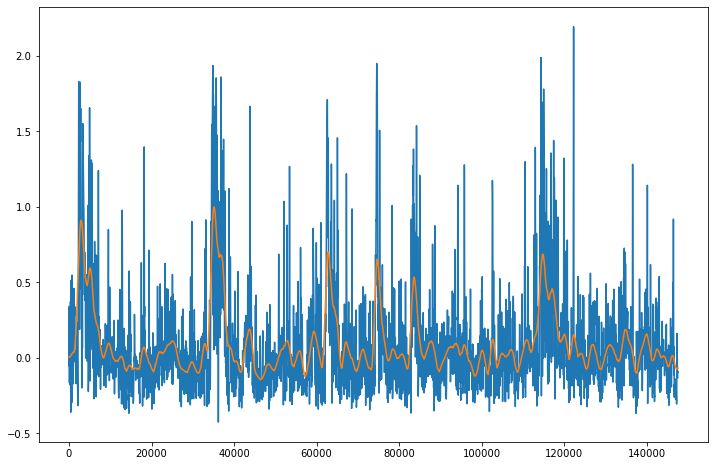

In [108]:

pred_s3_test_spline_gaus = convolve_gaussian(pred_s3_test_spline)

print(pred_s3_test_spline_gaus.shape)
plt.figure(figsize=(12,8))
plt.plot(pred_s3_test_spline.transpose()[0])
plt.plot(pred_s3_test_spline_gaus.transpose()[0])



(147500, 5)


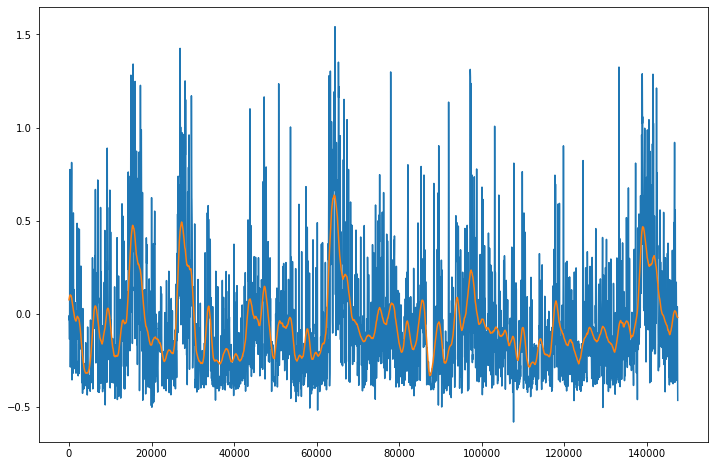

In [109]:
pred_s1_test_spline_gaus = convolve_gaussian(pred_s1_test_spline)

print(pred_s3_test_spline_gaus.shape)
plt.figure(figsize=(12,8))
plt.plot(pred_s1_test_spline.transpose()[0])
plt.plot(pred_s1_test_spline_gaus.transpose()[0])


In [110]:
from scipy.io import savemat

In [113]:
pred1_test_postprocess = convolve_gaussian(spline_preds(pred_s1_test, 147500)) 
pred2_test_postprocess = convolve_gaussian(spline_preds(pred_s2_test, 147500)) 
pred3_test_postprocess = convolve_gaussian(spline_preds(pred_s3_test, 147500)) 

#pred1_test_postprocess[pred1_test_postprocess > 0] = pred1_test_postprocess[pred1_test_postprocess > 0] * 3
#pred2_test_postprocess[pred2_test_postprocess > 0] = pred2_test_postprocess[pred2_test_postprocess > 0] * 3
#pred2_test_postprocess[pred3_test_postprocess > 0] = pred3_test_postprocess[pred3_test_postprocess > 0] * 3

print(np.shape(pred1_test_postprocess))
print(np.shape(pred1_test_postprocess))
print(np.shape(pred1_test_postprocess))

predictions_array = np.zeros((3,1), dtype=object)
predictions_array[0,0] = pred1_test_postprocess
predictions_array[1,0] = pred2_test_postprocess
predictions_array[2,0] = pred3_test_postprocess

savemat('predictions_rfr1000_run2_gaus3.mat', {'predicted_dg':predictions_array})

[0.00000000e+00 1.99933559e-02 3.99867118e-02 ... 2.94896001e+03
 2.94898001e+03 2.94900000e+03]
[0.00000000e+00 1.99933559e-02 3.99867118e-02 ... 2.94896001e+03
 2.94898001e+03 2.94900000e+03]
[0.00000000e+00 1.99933559e-02 3.99867118e-02 ... 2.94896001e+03
 2.94898001e+03 2.94900000e+03]
(147500, 5)
(147500, 5)
(147500, 5)


In [112]:
predictions_array = np.zeros((3,1), dtype=object)
predictions_array[0,0] = pred_s1_test_spline
predictions_array[1,0] = pred_s2_test_spline
predictions_array[2,0] = pred_s3_test_spline

savemat('predictions_rfr1000_run2_no_gaus.mat', {'predicted_dg':predictions_array})